In [1]:
import matplotlib.pyplot as plt
from data_generation import MEANS, VARIANCES, KEY, generate_mv_data, NUM_SAMPLES
from plot_utils import plot_scatter, plot_circles, plot_metrics
from train_utils import SimpleDnn, Encoder, Linear_Encoder, create_loaders
import torch
from torch.utils.data import TensorDataset
import numpy as np
import pytorch_lightning as pl
from pytorch_lightning.loggers import CSVLogger
import torch.nn.functional as F
import pandas as pd
from sklearn.datasets import make_circles
import matplotlib.image as image
from matplotlib.offsetbox import (OffsetImage, AnnotationBbox)
import plotly.express as px
from csv_utils import format_csv
from pathlib import Path
import weightwatcher as ww

BATCH_SIZE = 32

# Linear Data Example

1. Generate linear data from three Gaussians

In [2]:
# generate data
data, labels = generate_mv_data(KEY, MEANS, VARIANCES, NUM_SAMPLES, 3)

# format labels and set up dataloaders
labels_one_hot = F.one_hot(torch.Tensor(np.hstack((np.array(labels)))).to(torch.int64), num_classes=3).float() 
data_linear = TensorDataset(
                torch.Tensor(np.vstack((np.array(data)))), labels_one_hot
            )
train_loader_linear, val_loader_linear = create_loaders(data = data_linear, ratio = 0.8, num_workers = 0, shuffle_train = True, shuffle_val = False, batch_size = 32)

2023-04-03 15:27:27.888 | INFO     | train_utils:create_loaders:44 - Creating dataloaders with 80/20train/test split 🔪
2023-04-03 15:27:27.889 | INFO     | train_utils:create_loaders:70 - Successfully created train and validation loader 🤗


### 1. Train 'unbroken' model (simple feed-forward network)

In [10]:
# define model and logger
simple_dnn = SimpleDnn(Encoder(input_dim = 2, output_dim = 3), task_type = 'classification')
csv_logger = CSVLogger(save_dir='metrics_csv', name = 'linear')
# train model on linear data
trainer = pl.Trainer(logger=csv_logger, max_epochs = 50, log_every_n_steps=20)
trainer.fit(model=simple_dnn, train_dataloaders = train_loader_linear, val_dataloaders = val_loader_linear)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/clarahoffmann/Documents/code/pycon_2023_honey_i_broke_the_pytorch_model/.venv/lib/python3.9/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:612: UserWarning: Checkpoint directory metrics_csv/linear/version_0/checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")

  | Name    | Type          | Params
------------------------------------------
0 | encoder | Encoder       | 63    
1 | f1      | BinaryF1Score | 0     
------------------------------------------
63        Trainable params
0         Non-trainable params
63        Total params
0.000     Total estimated model params size (MB)
/Users/clarahoffmann/Documents/code/pycon_2023_honey_i_broke_the_pytorch_model/.venv/lib/python3.9/site-packages/lightning_fabric/loggers/csv_logs.py:188: UserWarning: Experiment log

Epoch 49: 100%|██████████| 38/38 [00:00<00:00, 177.47it/s, v_num=0]         

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 38/38 [00:00<00:00, 173.16it/s, v_num=0]


In [11]:
# format, since csv logger captures metrics on step basis
format_csv('metrics_csv/linear/version_0/metrics.csv', ['train_loss', 'val_loss'], Path('reformatted_metrics/linear_data.csv'))

### 2. Broken model: No activation functions

In [12]:
# DNN without ReLUs
simple_dnn_linear = SimpleDnn(Linear_Encoder(input_dim = 2, output_dim = 3), task_type = 'classification')
csv_logger = CSVLogger(save_dir='metrics_csv', name = 'linear_no_relu')
# train model on linear data
trainer = pl.Trainer(logger=csv_logger, max_epochs = 50, log_every_n_steps=20)
trainer.fit(model=simple_dnn_linear, train_dataloaders = train_loader_linear, val_dataloaders = val_loader_linear)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/clarahoffmann/Documents/code/pycon_2023_honey_i_broke_the_pytorch_model/.venv/lib/python3.9/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:612: UserWarning: Checkpoint directory metrics_csv/linear_no_relu/version_0/checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")

  | Name    | Type           | Params
-------------------------------------------
0 | encoder | Linear_Encoder | 63    
1 | f1      | BinaryF1Score  | 0     
-------------------------------------------
63        Trainable params
0         Non-trainable params
63        Total params
0.000     Total estimated model params size (MB)
/Users/clarahoffmann/Documents/code/pycon_2023_honey_i_broke_the_pytorch_model/.venv/lib/python3.9/site-packages/lightning_fabric/loggers/csv_logs.py:188: UserWarning: E

/Users/clarahoffmann/Documents/code/pycon_2023_honey_i_broke_the_pytorch_model/.venv/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:430: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/Users/clarahoffmann/Documents/code/pycon_2023_honey_i_broke_the_pytorch_model/.venv/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:430: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Epoch 49: 100%|██████████| 38/38 [00:00<00:00, 152.62it/s, v_num=0]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 38/38 [00:00<00:00, 149.26it/s, v_num=0]


In [13]:
# format, since csv logger captures metrics on step basis
format_csv('metrics_csv/linear_no_relu/version_0/metrics.csv', ['train_loss', 'val_loss'], Path('reformatted_metrics/linear_data_no_relu.csv'))

# Nonlinear Data Example

In [2]:
data_circles, label_circles = make_circles(n_samples=NUM_SAMPLES, factor=0.5, noise=0.05)
# concentric circles
data_tensor_circles = TensorDataset(
                torch.Tensor(data_circles), F.one_hot(torch.Tensor(label_circles).to(torch.int64), num_classes=2).float() 
            )
train_loader_circles, val_loader_circles = create_loaders(data = data_tensor_circles, ratio = 0.8,  batch_size = 32, num_workers = 0,
                                                        shuffle_train = True, shuffle_val = False)

2023-04-06 13:00:54.133 | INFO     | train_utils:create_loaders:44 - Creating dataloaders with 80/20train/test split 🔪
2023-04-06 13:00:54.138 | INFO     | train_utils:create_loaders:70 - Successfully created train and validation loader 🤗


### 1. Train 'unbroken' model (simple feed-forward network)

In [16]:
simple_dnn = SimpleDnn(Encoder(input_dim = 2, output_dim = 2), task_type = 'classification')
csv_logger = CSVLogger(save_dir='metrics_csv', name = 'circles')
# train model on nonlinear data
trainer = pl.Trainer(logger=csv_logger, max_epochs = 50)
trainer.fit(model=simple_dnn, train_dataloaders = train_loader_circles, val_dataloaders = val_loader_circles)
format_csv('metrics_csv/circles/version_0/metrics.csv', ['train_loss', 'val_loss'], Path('reformatted_metrics/circle_data.csv'))

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: metrics_csv/circles

  | Name    | Type          | Params
------------------------------------------
0 | encoder | Encoder       | 52    
1 | f1      | BinaryF1Score | 0     
------------------------------------------
52        Trainable params
0         Non-trainable params
52        Total params
0.000     Total estimated model params size (MB)


/Users/clarahoffmann/Documents/code/pycon_2023_honey_i_broke_the_pytorch_model/.venv/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:430: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/Users/clarahoffmann/Documents/code/pycon_2023_honey_i_broke_the_pytorch_model/.venv/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:430: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/Users/clarahoffmann/Documents/code/pycon_2023_honey_i_broke_the_pytorch_model

Epoch 49: 100%|██████████| 13/13 [00:00<00:00, 171.54it/s, v_num=0]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 13/13 [00:00<00:00, 161.16it/s, v_num=0]


### 2. Broken model: No activation functions

In [18]:
# DNN without ReLUs
simple_dnn_linear = SimpleDnn(Linear_Encoder(input_dim = 2, output_dim = 2), task_type = 'classification')
# train model on nonlinear data
csv_logger = CSVLogger(save_dir='metrics_csv', name = 'circles_no_relu')
trainer = pl.Trainer(logger=csv_logger, max_epochs = 50)
trainer.fit(model=simple_dnn_linear, train_dataloaders = train_loader_circles, val_dataloaders = val_loader_circles)
format_csv('metrics_csv/circles_no_relu/version_0/metrics.csv', ['train_loss', 'val_loss'], Path('reformatted_metrics/circle_data_no_relu.csv'))

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: metrics_csv/circles_no_relu

  | Name    | Type           | Params
-------------------------------------------
0 | encoder | Linear_Encoder | 52    
1 | f1      | BinaryF1Score  | 0     
-------------------------------------------
52        Trainable params
0         Non-trainable params
52        Total params
0.000     Total estimated model params size (MB)


/Users/clarahoffmann/Documents/code/pycon_2023_honey_i_broke_the_pytorch_model/.venv/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:430: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/Users/clarahoffmann/Documents/code/pycon_2023_honey_i_broke_the_pytorch_model/.venv/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:430: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/Users/clarahoffmann/Documents/code/pycon_2023_honey_i_broke_the_pytorch_model

Epoch 49: 100%|██████████| 13/13 [00:00<00:00, 142.19it/s, v_num=0]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 13/13 [00:00<00:00, 132.34it/s, v_num=0]


### 3. Broken model: Frozen weights

In [148]:
simple_dnn_frozen_weights = SimpleDnn(Encoder(input_dim = 2, output_dim = 2), task_type = 'classification')

num_params = len([param for param in simple_dnn.parameters()])
for i, param in zip(range(num_params), simple_dnn.parameters()):
    if i in [num_params-1, num_params -2] :
        param.requires_grad = False

csv_logger = CSVLogger(save_dir='metrics_csv', name = 'circles_frozen')
# train model on nonlinear data
trainer = pl.Trainer(logger=csv_logger, max_epochs = 50)
trainer.fit(model=simple_dnn_frozen_weights, train_dataloaders = train_loader_circles, val_dataloaders = val_loader_circles)
format_csv('metrics_csv/circles_frozen/version_0/metrics.csv', ['train_loss', 'val_loss'], Path('reformatted_metrics/circle_data_frozen.csv'))

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name    | Type          | Params
------------------------------------------
0 | encoder | Encoder       | 52    
1 | f1      | BinaryF1Score | 0     
------------------------------------------
52        Trainable params
0         Non-trainable params
52        Total params
0.000     Total estimated model params size (MB)


Epoch 49: 100%|██████████| 13/13 [00:00<00:00, 112.61it/s, v_num=0]         

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 13/13 [00:00<00:00, 106.09it/s, v_num=0]


### 4. Broken model: Frozen Bias

In [7]:
simple_dnn = SimpleDnn(Encoder(input_dim = 2, output_dim = 2), task_type = 'classification')

num_params = len([param for param in simple_dnn.parameters()])
for i, param in zip(range(num_params), simple_dnn.parameters()):
    if i == num_params-1 :
        param.requires_grad = False

csv_logger = CSVLogger(save_dir='metrics_csv', name = 'circles_frozen_bias')
# train model on nonlinear data
trainer = pl.Trainer(logger=csv_logger, max_epochs = 50)
trainer.fit(model=simple_dnn, train_dataloaders = train_loader_circles, val_dataloaders = val_loader_circles)
format_csv('metrics_csv/circles_frozen_bias/version_0/metrics.csv', ['train_loss', 'val_loss'], Path('reformatted_metrics/circle_data_frozen_bias.csv'))

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/clarahoffmann/Documents/code/pycon_2023_honey_i_broke_the_pytorch_model/.venv/lib/python3.9/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:612: UserWarning: Checkpoint directory metrics_csv/circles_frozen_bias/version_0/checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")

  | Name    | Type          | Params
------------------------------------------
0 | encoder | Encoder       | 52    
1 | f1      | BinaryF1Score | 0     
------------------------------------------
50        Trainable params
2         Non-trainable params
52        Total params
0.000     Total estimated model params size (MB)
/Users/clarahoffmann/Documents/code/pycon_2023_honey_i_broke_the_pytorch_model/.venv/lib/python3.9/site-packages/lightning_fabric/loggers/csv_logs.py:188: UserWarning: E

/Users/clarahoffmann/Documents/code/pycon_2023_honey_i_broke_the_pytorch_model/.venv/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:430: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/Users/clarahoffmann/Documents/code/pycon_2023_honey_i_broke_the_pytorch_model/.venv/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:430: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/Users/clarahoffmann/Documents/code/pycon_2023_honey_i_broke_the_pytorch_model

Epoch 49: 100%|██████████| 13/13 [00:00<00:00, 56.09it/s, v_num=0] 

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 13/13 [00:00<00:00, 53.67it/s, v_num=0]


### 5. Broken model: Trainloader returns single example

In [130]:
simple_dnn = SimpleDnn(Encoder(input_dim = 2, output_dim = 2), task_type = 'classification')
train_loader_circles_broken, val_loader_circles = create_loaders(data = data_tensor_circles, ratio = 0.8,  batch_size = 32, num_workers = 0,
                                                        shuffle_train = True, shuffle_val = False, subset_broken_train = True)

csv_logger = CSVLogger(save_dir='metrics_csv', name = 'circles_dataloader_broken')
# train model on nonlinear data
trainer = pl.Trainer(logger=csv_logger, max_epochs = 50)
trainer.fit(model=simple_dnn, train_dataloaders = train_loader_circles_broken, val_dataloaders = val_loader_circles)
format_csv('metrics_csv/circles_dataloader_broken/version_0/metrics.csv', ['train_loss', 'val_loss'], Path('reformatted_metrics/circle_dataloader_broken.csv'))

2023-04-06 13:48:57.939 | INFO     | train_utils:create_loaders:44 - Creating dataloaders with 80/20train/test split 🔪
2023-04-06 13:48:57.943 | INFO     | train_utils:create_loaders:70 - Successfully created train and validation loader 🤗
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name    | Type          | Params
------------------------------------------
0 | encoder | Encoder       | 52    
1 | f1      | BinaryF1Score | 0     
------------------------------------------
52        Trainable params
0         Non-trainable params
52        Total params
0.000     Total estimated model params size (MB)


Epoch 49: 100%|██████████| 7/7 [00:00<00:00, 91.09it/s, v_num=0]            

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 7/7 [00:00<00:00, 80.91it/s, v_num=0]


## 6. Broken models with weightwatcher

In [298]:
class CustomEncoder(nn.Module):
    """
    Simple encoder
    """

    def __init__(self, input_dim: int, output_dim: int) -> None:
        """Setup model layers"""
        super().__init__()
        self.dense1 =  nn.Linear(input_dim, 10)
        self.dense2 = nn.Linear(10, 9)
        self.dense3 = nn.Linear(10, 8)
        self.dense4 = nn.Linear(10, 7)
        self.dense5 = nn.Linear(10, 6)
        self.dense6 = nn.Linear(10, output_dim)
        self.relu = nn.ReLU()

        
        self.output_dim = output_dim
        self.input_dim = input_dim

    def forward(self, x: torch.Tensor) -> nn.Sequential:
        """Forward pass through layers"""
        x = self.dense1(x)
        x = self.relu(x)
        x = self.dense2(x)
        x = self.relu(x)
        x = self.dense3(x)
        x = self.relu(x)
        x = self.dense4(x)
        x = self.relu(x)
        x = self.dense5(x)
        x = self.relu(x)
        x = self.dense6(x)
        return x

simple_dnn = SimpleDnn(CustomEncoder(input_dim = 2, output_dim = 2), task_type = 'classification')
train_loader_circles_broken, val_loader_circles = create_loaders(data = data_tensor_circles, ratio = 0.8,  batch_size = 32, num_workers = 0,
                                                        shuffle_train = True, shuffle_val = False, subset_broken_train = True)

csv_logger = CSVLogger(save_dir='metrics_csv', name = 'circles_dataloader_broken')
# train model on nonlinear data
trainer = pl.Trainer(logger=csv_logger, max_epochs = 50)
trainer.fit(model=simple_dnn, train_dataloaders = train_loader_circles_broken, val_dataloaders = val_loader_circles)
format_csv('metrics_csv/circles_dataloader_broken/version_0/metrics.csv', ['train_loss', 'val_loss'], Path('reformatted_metrics/circle_dataloader_broken.csv'))

2023-04-06 15:05:59.754 | INFO     | train_utils:create_loaders:44 - Creating dataloaders with 80/20train/test split 🔪
2023-04-06 15:05:59.773 | INFO     | train_utils:create_loaders:70 - Successfully created train and validation loader 🤗
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name    | Type          | Params
------------------------------------------
0 | encoder | CustomEncoder | 492   
1 | f1      | BinaryF1Score | 0     
------------------------------------------
492       Trainable params
0         Non-trainable params
492       Total params
0.002     Total estimated model params size (MB)


Epoch 49: 100%|██████████| 7/7 [00:00<00:00, 70.24it/s, v_num=0]            

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 7/7 [00:00<00:00, 59.35it/s, v_num=0]


In [310]:
simple_dnn_everything_ok = SimpleDnn(CustomEncoder(input_dim = 2, output_dim = 2), task_type = 'classification')
train_loader_circles, val_loader_circles = create_loaders(data = data_tensor_circles, ratio = 0.8,  batch_size = 32, num_workers = 0,
                                                        shuffle_train = True, shuffle_val = False, subset_broken_train = False)

csv_logger = CSVLogger(save_dir='metrics_csv', name = 'circles_dataloader_broken')
# train model on nonlinear data
trainer = pl.Trainer(logger=csv_logger, max_epochs = 50)
trainer.fit(model=simple_dnn, train_dataloaders = train_loader_circles, val_dataloaders = val_loader_circles)
format_csv('metrics_csv/circles_dataloader_broken/version_0/metrics.csv', ['train_loss', 'val_loss'], Path('reformatted_metrics/circle_dataloader_broken.csv'))

2023-04-06 15:08:12.919 | INFO     | train_utils:create_loaders:44 - Creating dataloaders with 80/20train/test split 🔪
2023-04-06 15:08:12.926 | INFO     | train_utils:create_loaders:70 - Successfully created train and validation loader 🤗
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name    | Type          | Params
------------------------------------------
0 | encoder | CustomEncoder | 492   
1 | f1      | BinaryF1Score | 0     
------------------------------------------
492       Trainable params
0         Non-trainable params
492       Total params
0.002     Total estimated model params size (MB)


Epoch 49: 100%|██████████| 13/13 [00:00<00:00, 101.04it/s, v_num=0]         

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 13/13 [00:00<00:00, 95.04it/s, v_num=0] 


In [311]:
ckpt = torch.load('metrics_csv/circles_dataloader_broken/version_0/checkpoints/epoch=49-step=350-v4.ckpt',map_location=torch.device('cpu') )
ckpt2 = torch.load('metrics_csv/circles_dataloader_broken/version_0/checkpoints/epoch=49-step=650.ckpt',map_location=torch.device('cpu') )

In [236]:
ckpt_comp = torch.load('metrics_csv/circles_dataloader_broken/version_0/checkpoints/casanovo_massivekb.ckpt',map_location=torch.device('cpu') )

In [300]:
ckpt['state_dict']

OrderedDict([('encoder.dense1.weight',
              tensor([[-0.5604, -0.2151],
                      [-0.4576, -0.0725],
                      [ 0.4301, -0.5347],
                      [ 0.8259,  0.2823],
                      [-0.1593,  0.5156],
                      [-0.1769,  0.3860],
                      [ 0.1119,  0.5649],
                      [ 0.6871, -0.6681],
                      [-0.1420, -0.6892],
                      [ 0.5562, -0.1265]])),
             ('encoder.dense1.bias',
              tensor([ 4.6227e-02, -5.7050e-01,  2.4760e-04,  1.4801e-01,  4.4884e-01,
                      -1.4908e-01,  2.3155e-01, -2.5623e-02, -2.5537e-02, -6.9192e-01])),
             ('encoder.dense2.weight',
              tensor([[ 0.2396, -0.2301,  0.0897,  0.2288, -0.2495, -0.2949, -0.3054, -0.2321,
                        0.3149, -0.2250],
                      [-0.0860,  0.2244, -0.2593,  0.1505,  0.0197, -0.2431, -0.2900, -0.1829,
                        0.0942,  0.0572],
           

In [313]:
#from torch import nn
watcher = ww.WeightWatcher(model=ckpt['state_dict'])
results = watcher.analyze()
summary = watcher.get_summary()
details = watcher.get_details()

In [314]:
#from torch import nn
watcher2 = ww.WeightWatcher(model=ckpt2['state_dict'])
results2 = watcher2.analyze()
summary2 = watcher2.get_summary()
details2 = watcher2.get_details()

In [316]:
details2

,layer_id,name,D,M,N,Q,alpha,alpha_weighted,entropy,has_esd,...,rf,sigma,spectral_norm,stable_rank,status,sv_max,warning,weak_rank_loss,xmax,xmin
0,2,encoder.dense2,0.186017,10,10,1.0,1.935996,1.569103,0.505361,True,...,1,0.467998,6.463809,1.578482,success,2.542402,over-trained,0,6.463809,0.529830
1,3,encoder.dense3,0.163146,10,10,1.0,2.143595,1.834972,0.499675,True,...,1,0.511431,7.178365,1.432198,success,2.679247,over-trained,0,7.178365,0.400411
2,4,encoder.dense4,0.149707,10,10,1.0,1.688058,1.429441,0.530479,True,...,1,0.260061,7.027424,1.649303,success,2.650929,over-trained,0,7.027424,0.163965
3,5,encoder.dense5,0.142799,10,10,1.0,1.785169,1.484335,0.551512,True,...,1,0.296766,6.783929,1.660889,success,2.604598,over-trained,0,6.783929,0.210894


(array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]),
 array([1.68805801, 1.69261338, 1.69716875, 1.70172412, 1.70627949,
        1.71083486, 1.71539023, 1.71994561, 1.72450098, 1.72905635,
        1.73361172, 1.73816709, 1.74272246, 1.74727783, 1.7518332 ,
        1.75638857, 1.76094394, 1.76549931, 1.77005468, 1.77461005,
        1.77916543, 1.7837208 , 1.78827617, 1.79283154, 1.79738691,
        1.80194228, 1.80649765, 1.81105302, 1.81560839, 1.82016376,
        1.82471913, 1.8292745 , 1.83382987, 1.83838525, 1.84294062,
        1.84749599, 1.85205136, 1.85660673, 1.8611621 , 1.86571747,
      

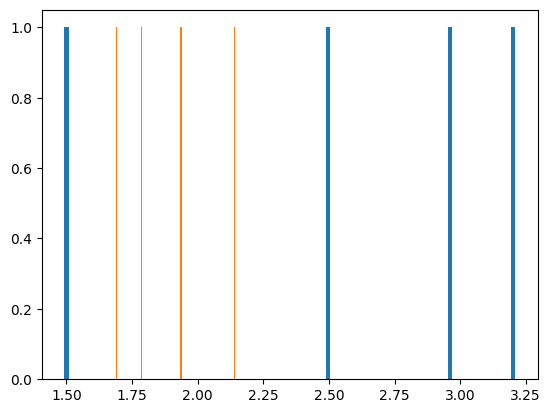

In [318]:
plt.hist(details['alpha'], bins = 100)
plt.hist(details2['alpha'], bins = 100)

In [137]:
simple_dnn_frozen_weights.encoder.layers[0].weight

Parameter containing:
tensor([[ 0.8656, -0.9720],
        [ 0.1698, -0.1095],
        [ 0.3996, -0.0151],
        [-0.2911,  1.1321],
        [-0.0911, -0.1955],
        [ 0.1058,  0.3385],
        [ 1.1042,  0.7654],
        [-0.8262, -0.8892],
        [ 1.2622, -0.1512],
        [-0.4184,  0.1098]], requires_grad=True)

In [95]:
model.features = simple_dnn.encoder.layers

In [89]:
details = watcher.analyze(plot=True)

In [79]:
watcher = ww.WeightWatcher(model= simple_dnn_linear.encoder)
results = watcher.analyze()
 
summary = watcher.get_summary()
details = watcher.get_details()

NameError: name 'simple_dnn_linear' is not defined

In [182]:
import torchvision.models as models
simple_dnn_frozen_weights_vgg_struct = models.vgg11(pretrained=True)

In [187]:
simple_dnn_frozen_weights_vgg_struct.classifier = simple_dnn_frozen_weights.encoder.layers

In [196]:
simple_dnn_frozen_weights

SimpleDnn(
  (encoder): Encoder(
    (layers): Sequential(
      (0): Linear(in_features=2, out_features=10, bias=True)
      (1): ReLU()
      (2): Linear(in_features=10, out_features=2, bias=True)
    )
  )
  (f1): BinaryF1Score()
  (features): Sequential(
    (0): Linear(in_features=2, out_features=10, bias=True)
    (1): ReLU()
    (2): Linear(in_features=10, out_features=2, bias=True)
  )
)

In [168]:
simple_dnn_frozen_weights_vgg_struct.modules = simple_dnn_frozen_weights.modules
simple_dnn_frozen_weights_vgg_struct.features = simple_dnn_frozen_weights.encoder.layers

In [197]:
#model = models.vgg11(pretrained=True)
watcher_frozen = ww.WeightWatcher(model=simple_dnn_frozen_weights.encoder)
results_frozen = watcher_frozen.analyze()
 
summary_frozen = watcher_frozen.get_summary()
details_frozen = watcher_frozen.get_details()

In [198]:
details_frozen

""


In [124]:
import matplotlib.pyplot as plt

(array([1., 0., 1., 0., 0., 0., 0., 0., 0., 1.]),
 array([2.16194935, 2.22998845, 2.29802755, 2.36606666, 2.43410576,
        2.50214486, 2.57018396, 2.63822306, 2.70626216, 2.77430126,
        2.84234037]),
 <BarContainer object of 10 artists>)

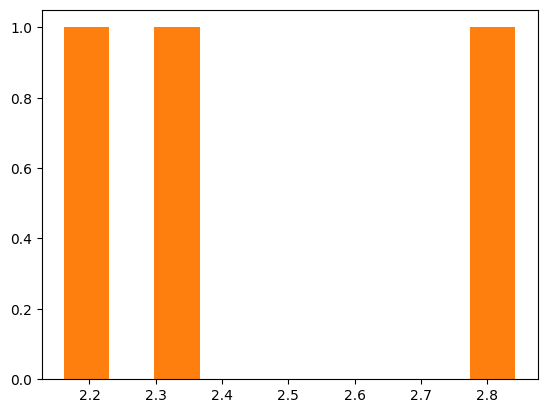

In [171]:
plt.hist(details['alpha'])
plt.hist(details_frozen['alpha'])

In [116]:
px.histogram(details_frozen['alpha'], nbins = 100)

ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

Figure({
    'data': [{'alignmentgroup': 'True',
              'bingroup': 'x',
              'hovertemplate': 'variable=alpha<br>value=%{x}<br>count=%{y}<extra></extra>',
              'legendgroup': 'alpha',
              'marker': {'color': '#636efa', 'pattern': {'shape': ''}},
              'name': 'alpha',
              'nbinsx': 100,
              'offsetgroup': 'alpha',
              'orientation': 'v',
              'showlegend': True,
              'type': 'histogram',
              'x': array([2.40071198, 1.72079259, 3.04786185, 5.66726433, 2.65181715, 3.20573868,
                          3.48971467, 3.26126163, 2.32202354, 2.16194935, 2.84234037]),
              'xaxis': 'x',
              'yaxis': 'y'}],
    'layout': {'barmode': 'relative',
               'legend': {'title': {'text': 'variable'}, 'tracegroupgap': 0},
               'margin': {'t': 60},
               'template': '...',
               'xaxis': {'anchor': 'y', 'domain': [0.0, 1.0], 'title': {'text': 'value'}},
               'yaxis': {'anchor': 'x', 'domain': [0.0, 1.0], 'title': {'text': 'count'}}}
})

In [110]:
import plotly.graph_objects as go

In [ ]:
#model = models.vgg11(pretrained=True)
watcher = ww.WeightWatcher(model=simple_dnn_frozen_weights)
results = watcher.analyze()
 
summary = watcher.get_summary()
details = watcher.get_details()

In [101]:
details['alpha']

0    2.322024
1    2.161949
2    2.842340
Name: alpha, dtype: float64

In [102]:
px.histogram(details['alpha'], nbins = 100)

ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

Figure({
    'data': [{'alignmentgroup': 'True',
              'bingroup': 'x',
              'hovertemplate': 'variable=alpha<br>value=%{x}<br>count=%{y}<extra></extra>',
              'legendgroup': 'alpha',
              'marker': {'color': '#636efa', 'pattern': {'shape': ''}},
              'name': 'alpha',
              'nbinsx': 100,
              'offsetgroup': 'alpha',
              'orientation': 'v',
              'showlegend': True,
              'type': 'histogram',
              'x': array([2.32202354, 2.16194935, 2.84234037]),
              'xaxis': 'x',
              'yaxis': 'y'}],
    'layout': {'barmode': 'relative',
               'legend': {'title': {'text': 'variable'}, 'tracegroupgap': 0},
               'margin': {'t': 60},
               'template': '...',
               'xaxis': {'anchor': 'y', 'domain': [0.0, 1.0], 'title': {'text': 'value'}},
               'yaxis': {'anchor': 'x', 'domain': [0.0, 1.0], 'title': {'text': 'count'}}}
})

In [48]:
model.__dict__

{'training': True,
 '_parameters': OrderedDict(),
 '_buffers': OrderedDict(),
 '_non_persistent_buffers_set': set(),
 '_backward_pre_hooks': OrderedDict(),
 '_backward_hooks': OrderedDict(),
 '_is_full_backward_hook': None,
 '_forward_hooks': OrderedDict(),
 '_forward_hooks_with_kwargs': OrderedDict(),
 '_forward_pre_hooks': OrderedDict(),
 '_forward_pre_hooks_with_kwargs': OrderedDict(),
 '_state_dict_hooks': OrderedDict(),
 '_state_dict_pre_hooks': OrderedDict(),
 '_load_state_dict_pre_hooks': OrderedDict(),
 '_load_state_dict_post_hooks': OrderedDict(),
 '_modules': OrderedDict([('features',
               Sequential(
                 (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
                 (1): ReLU(inplace=True)
                 (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
                 (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
                 (4): ReLU(inplace=True)
                